# Dataset Acquisition

This is a simple utility to help download and pare down the original dataset

In [10]:
import pandas as pd
import re
import os
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

pd.options.display.max_rows = 999
sns.set()
%matplotlib inline

## Look at the dataset description

In [11]:
# Load the Dataset description
df = pd.read_csv('all_data_info.csv')
print(f'Length: {len(df)}')
print(f'{round(df.size_bytes.sum()/1000000000,1)} GB')

# Check for missing values
df.isna().sum()

Length: 103250
40.1 GB


artist              0
date            26363
genre            1254
pixelsx             0
pixelsy             0
size_bytes          0
source            167
style             986
title             122
artist_group        0
in_train            0
new_filename        0
dtype: int64

In [12]:
# Clean the Date Field
def clean_date(date_str):
    if pd.isnull(date_str):
        return None
    
    re_ = re.search('(\d\d\d\d?)', date_str)
    if not re_:
        print(f'No match on {date_str}')
        return None
    
    return re_.group(1)

df['date'] = df.date.map(clean_date).astype(float)

No match on ific
No match on rain
No match on rver


In [13]:
# Look at the breakdowns by style

style_df = df.groupby('style').agg(
    {'size_bytes' : 'sum', 'artist' : 'count', 'date' : 'mean'}).rename(
    {'artist' : 'count'}, axis = 'columns').sort_values('count', ascending = False)

def display_size(bytes_):
    return str(round(bytes_/1000000000,1)) + ' GB'

style_df['size_bytes'] = style_df.size_bytes.map(display_size)
style_df.to_csv('style-breakdown.csv')
print(f'{len(style_df)} styles')
style_df

136 styles


,size_bytes,count,date
style,,,
Impressionism,4.6 GB,10643,1895.697380
Realism,3.6 GB,10523,1885.592199
Romanticism,3.6 GB,9285,1848.410370
Expressionism,1.9 GB,7013,1934.248116
Post-Impressionism,2.4 GB,5778,1911.790857
Art Nouveau (Modern),3.9 GB,4899,1908.569947
Baroque,1.8 GB,4400,1651.675612
Surrealism,1.3 GB,4167,1948.615335
Symbolism,1.9 GB,3476,1903.205618


In [14]:
# Look at the breakdowns by artist

artist_df = df.groupby('artist').agg(
    {'size_bytes' : 'sum', 'new_filename' : 'count'}).rename(
    {'new_filename' : 'count'}, axis = 'columns').sort_values('count', ascending = False)

def display_size(bytes_):
    return str(round(bytes_/1000000,1)) + ' MB'

artist_df['size_bytes'] = artist_df.size_bytes.map(display_size)
artist_df = artist_df[artist_df['count'] >= 100]

artist_df.to_csv('artist-breakdown.csv')
print(f'{len(artist_df)} artists with at least 100 paintings')
artist_df

257 artists with at least 100 paintings


,size_bytes,count
artist,,
John Singer Sargent,154.0 MB,500
Rembrandt,274.1 MB,500
Pablo Picasso,232.4 MB,500
Ivan Shishkin,123.3 MB,500
Ivan Aivazovsky,110.8 MB,500
Giovanni Battista Piranesi,618.3 MB,500
Gustave Dore,352.7 MB,500
Pierre-Auguste Renoir,198.1 MB,500
Ilya Repin,86.0 MB,500


## Process the Files

In [15]:
def get_lookup_dict(col):
    return dict(df.set_index('new_filename')[[col]].to_records())

In [16]:
artist_lookup = get_lookup_dict('artist')
style_lookup  = get_lookup_dict('style')

In [17]:
# Hand annotated to select a handful (about 50) of artists whos work should be retained
good_artists = pd.read_excel('artist-breakdown-annotated.xlsx')
good_artists = good_artists[good_artists.fillna(0).keep.astype(bool)].artist.tolist()

In [18]:
# Downloading. Comment line 6 to actually do the download
#  Requires kaggle API installation (conda install kaggle)

to_download = [f'train_{i}' for i in range(0,10)]
to_download.append('test')
to_download.append('replacements_for_corrupted_files')
to_download = [] # Comment this out if you want to do the download
print(f'Downloading: {to_download}')


for download_file in to_download:
    if not os.path.exists('./' + download_file + '.zip'):
        print(f'Downloading {download_file}\n'
               'View progress in notebook terminal')
        os.system(f'kaggle competitions download -f {download_file}.zip painter-by-numbers')

    print(f'Extracting {download_file}')
    with zipfile.ZipFile('./' + download_file + '.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

    dir_name = f'./{download_file}/'
    print(f'Processing {download_file}')
    image_names = os.listdir(dir_name)

    for file in image_names:
        artist = artist_lookup[file]
        if artist in good_artists:
            os.rename(dir_name + file, './images/' + file)
        else:
            os.remove(dir_name + file)

    os.remove(download_file + '.zip')
    os.removedirs(dir_name)
    print(f'Done with {download_file}\n----------------------------\n')
    

Downloading: []


## Look at statistics for the resulting images

In [19]:
df_trimmed = df[df.artist.isin(good_artists)]

print(f'{len(df_trimmed.artist.unique())} artists included')

# Artists mostly are in one style with a few miscellany
print(df_trimmed.groupby(['artist', 'style']).apply(len).reset_index())

53 artists included
                      artist                         style    0
0          Wassily Kandinsky                  Abstract Art  133
1          Wassily Kandinsky          Art Nouveau (Modern)    3
2          Wassily Kandinsky                 Expressionism   55
3          Wassily Kandinsky            Post-Impressionism   23
4             Albrecht Durer          Northern Renaissance  499
5          Amedeo Modigliani                 Expressionism  342
6                Andy Warhol        Abstract Expressionism    3
7                Andy Warhol       Naïve Art (Primitivism)    1
8                Andy Warhol                       Pop Art  183
9               Claude Monet                 Impressionism  494
10              Claude Monet                       Realism    4
11                Cy Twombly        Abstract Expressionism   73
12                Cy Twombly                    Minimalism    3
13                Cy Twombly             Neo-Expressionism   37
14              Dieg

Look at the aspect ratios
count    14703.000000
mean         1.119409
std          0.369298
min          0.055972
25%          0.785904
50%          1.200000
75%          1.352044
max          4.322884
dtype: float64


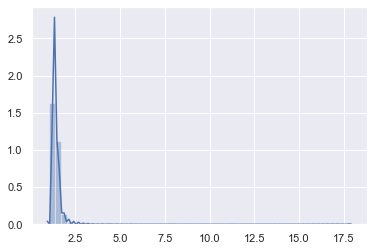

In [20]:
# Aspect Ratio
print('Look at the aspect ratios')
aspect = df_trimmed.pixelsy/df_trimmed.pixelsx
print(aspect.describe())
max_aspect = aspect.apply(lambda x : 1/x if x < 1 else x)
sns.distplot(max_aspect)
plt.show()

Look at the width
count    14703.000000
mean      1127.803373
std        594.479816
min        300.000000
25%        722.000000
50%        983.000000
75%       1354.000000
max       8533.000000
Name: pixelsx, dtype: float64


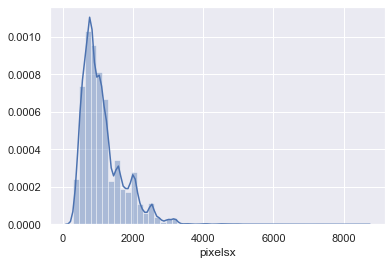

In [21]:
# Sizing
print('Look at the width')

print(df_trimmed.pixelsx.describe())

sns.distplot(df_trimmed.pixelsx)
plt.show()

Look at the size
count    1.470300e+04
mean     1.630612e+06
std      1.843215e+06
min      1.500800e+05
25%      5.755885e+05
50%      9.287950e+05
75%      2.038482e+06
max      3.690522e+07
dtype: float64


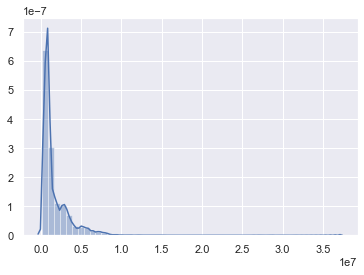

In [22]:
# Look at the total size
print('Look at the size')
size = df_trimmed.pixelsx * df_trimmed.pixelsy

print(size.describe())

sns.distplot(size)
plt.show()

## Dataset Summary for Presentation

In [23]:
df_trimmed

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
18,Hieronymus Bosch,1515.0,religious painting,8533.0,4325.0,6675952.0,wikiart,Northern Renaissance,The Garden of Earthly Delights,train_and_test,True,82352.jpg
20,Mark Rothko,1968.0,abstract,4912.0,7360.0,4666915.0,wikiart,Abstract Art,Untitled,train_and_test,False,85864.jpg
32,Diego Velazquez,1645.0,self-portrait,4841.0,5947.0,8157404.0,wikiart,Baroque,Self-portrait,train_and_test,True,70728.jpg
37,Titian,1562.0,self-portrait,4524.0,6018.0,8847626.0,wikiart,Mannerism (Late Renaissance),Self-portrait,train_and_test,False,15715.jpg
41,Georges Seurat,1884.0,NaN,6367.0,4226.0,11579390.0,wikipedia,Pointillism,Bathers at Asnières,train_and_test,True,39751.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
103090,Andy Warhol,1962.0,advertisement,337.0,450.0,20328.0,wikiart,Pop Art,3 Coke Bottles,train_and_test,True,50089.jpg
103125,M.C. Escher,1946.0,cityscape,356.0,425.0,79585.0,wikiart,Surrealism,"Street in Scanno, Abruzzi",train_and_test,True,73267.jpg
103155,Mark Rothko,1961.0,abstract,500.0,302.0,24397.0,wikiart,Color Field Painting,"No. 14 (Horizontals, White over Darks)",train_and_test,True,8717.jpg
103242,Michelangelo,1509.0,nude painting (nu),314.0,478.0,32773.0,wikiart,High Renaissance,Ignudo,train_and_test,False,12758.jpg


In [38]:
# Look at the breakdowns by style

style_df = df_trimmed.groupby('style').agg(
    {'artist' : 'count'}).rename(
    {'artist' : 'count'}, axis = 'columns').sort_values('count', ascending = False)

style_df.to_csv('trimmed-style-breakdown.csv')
print(f'{len(style_df)} styles')
style_df

51 styles


,count
style,
Impressionism,2474
Surrealism,1625
Expressionism,1367
Post-Impressionism,1132
Romanticism,1068
Realism,867
Northern Renaissance,682
Baroque,633
High Renaissance,605


In [146]:
from math import floor

df_trimmed = df_trimmed.assign(century = (df_trimmed['date']/100).map(floor, na_action = 'ignore'))
df_trimmed['century'] = (df_trimmed['century'] * 100)
centuries = df_trimmed.century.value_counts(dropna = False)
centuries.reset_index().to_csv('centuries.csv')

centuries = centuries.reset_index().fillna(2100)

centuries['index'] = centuries['index'].astype(int)
centuries = centuries.sort_values('index')
centuries['index'] = centuries['index'].astype(str)
centuries['index'].iloc[-1] = 'N/A'

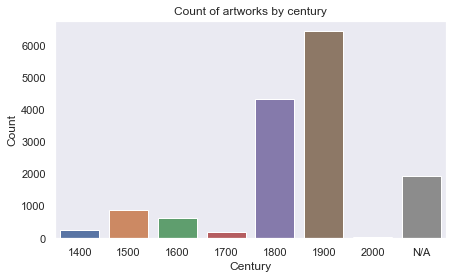

In [150]:
fig, ax = plt.subplots(figsize = (7, 4));
sns.barplot(x = 'index', y = 'century', data = centuries, ax = ax);
ax.set_xlabel('Century')
ax.set_ylabel('Count')
ax.set_title('Count of artworks by century')

fig.savefig('Artwork by Century.png')
plt.show()

In [ ]:
# Look at the breakdowns by artist

artist_df = df.groupby('artist').agg(
    {'size_bytes' : 'sum', 'new_filename' : 'count'}).rename(
    {'new_filename' : 'count'}, axis = 'columns').sort_values('count', ascending = False)

def display_size(bytes_):
    return str(round(bytes_/1000000,1)) + ' MB'

artist_df['size_bytes'] = artist_df.size_bytes.map(display_size)
artist_df = artist_df[artist_df['count'] >= 100]

artist_df.to_csv('artist-breakdown.csv')
print(f'{len(artist_df)} artists with at least 100 paintings')
artist_df

## Organize the Images into subfolders

In [14]:
dir_name = './images/'
image_names = os.listdir(dir_name)

for image in image_names:
    # See if the file is still here and check it is a file
    if not os.path.exists(dir_name + image) or os.path.isdir(dir_name + image):
        continue
    
    if image not in artist_lookup:
        continue
        
    subdir = dir_name + artist_lookup[image] + '/'
    if not os.path.exists(subdir):
        os.mkdir(subdir)
    os.rename(dir_name + image, subdir + image)

## Train Test Split

In [24]:
train_all, test = train_test_split(df_trimmed, test_size = 0.2, random_state = 42, stratify = df_trimmed.artist)
train, validate = train_test_split(train_all, test_size = 0.2, random_state = 42, stratify = train_all.artist)
print(f'Sizes:\n'
      f' Train    : {len(train)}\n'
      f' Test     : {len(test)}\n'
      f' Validate : {len(validate)}'
     )

Sizes:
 Train    : 9409
 Test     : 2941
 Validate : 2353


In [ ]:
# Make the directory structure
for dir_ in ['./train/', './test/', './validate/']:
    if not os.path.exists(dir_):
        os.mkdir(dir_)
    for artist in good_artists:
        if not os.path.exists(dir_ + artist):
            os.mkdir(dir_ + artist)

In [ ]:
for dir_, set_ in [
    ('./train/'   , train),
    ('./test/'    , test ),
    ('./validate/', validate)
]:
    for i in range(len(set_)):
        artist   = set_.artist.iloc[i]
        filename = set_.new_filename.iloc[i]
        src      = f'./images/{artist}/{filename}'
        dest     = dir_ + f'{artist}/{filename}'
        if os.path.exists(src):
            os.rename(src, dest)

In [ ]:
for artist in good_artists:
    if os.path.exists(f'./images/{artist}'):
        os.removedirs(f'./images/{artist}')

In [ ]:
for dir_ in ['train', 'test', 'validate']:
    if os.path.exists(dir_):
        os.rename(f'./{dir_}', f'./images/{dir_}')

## Delete Corrupted Files

In [ ]:
for root, subdirs, files in os.walk('../dataset/images'):
    for file in files:
        try:
            file_path = root + '/' + file
            img = tf.io.read_file(file_path)
            img = tf.image.decode_jpeg(img, channels=3)
        except tf.errors.InvalidArgumentError:
            if file_path.endswith('.jpg'):
                os.remove(file_path)
                print(f'Deleting image {file_path}')